# Import Library

In [21]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix,accuracy_score
from matplotlib import pyplot
import time
import io

from google.colab import files

# Import Data

In [22]:
df1 = pd.read_csv("datall.csv").drop(columns=['Unnamed: 0'])
df2 = pd.read_csv("data_tambahan_ok.csv")
df = pd.concat([df1, df2]).reset_index().drop(columns=['index'])
df

,rs4341,rs4961,rs4994,rs17249754,rs2681472,rs1800247,rs3781719,rs1799998,rs11191548,rs9266359,...,rs1800206,rs4253778,rs11099098,rs2296545,rs1122608,rs6749447,rs2361159,rs2021783,rs6013382,status
0,GG,GG,AA,GG,AA,0,AG,GG,TT,0,...,CC,0,0,CG,GT,GT,CC,CC,CT,normal
1,GG,TT,AA,AG,AG,0,AG,AG,TT,0,...,CC,0,0,CG,GG,GT,TT,CC,CT,hyper
2,GG,TT,AA,AG,AG,0,AG,AG,TT,0,...,CC,0,0,CG,GG,GT,TT,CC,CT,hyper
3,GG,TT,AA,AG,AG,TT,AG,AG,TT,CC,...,CC,GG,GG,CG,GG,GT,TT,CC,CT,hyper
4,CG,GG,GG,AG,AG,0,AA,AG,TT,0,...,CC,0,0,CC,GT,TT,CC,CC,CT,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,CG,GT,AG,GG,AA,TT,AA,AG,TT,0,...,CC,CG,GG,0,GG,TT,T,CC,TT,hyper
138,0,GG,AA,0,AA,TT,0,AA,TT,0,...,CC,CG,TG,0,GG,TT,TC,CC,CC,hyper
139,GG,GG,GG,AG,AG,TT,AA,AG,CT,0,...,CC,GG,GT,0,GG,GT,T,CC,TT,normal
140,GG,GG,GG,AG,AG,TT,AA,AG,TC,0,...,CC,GG,TG,0,GG,TG,TT,CC,TT,normal


# Preprocessing

Mencetak data pertama

In [23]:
# df.iloc[0]

In [24]:
# df.info()

Rename kolom paling akhir menjadi label

In [25]:
df.rename(columns={df.columns[-1]: 'label'}, inplace=True)

In [26]:
# df.head()

In [27]:
df.to_excel("pre_encoding_data.xlsx")

Replace Karakter Menjadi Numeric (Sum)


In [28]:
df = df.replace({'A': '0'}, regex=True) # A: 00
df = df.replace({'T': '1'}, regex=True) # T: 01
df = df.replace({'G': '2'}, regex=True) # G: 10
df = df.replace({'C': '3'}, regex=True) # C: 11

df = df.replace({'hyper': 1}, regex=True)
df = df.replace({'normal': 0}, regex=True)

In [29]:
df.to_excel("post_encoding_data.xlsx")

In [30]:
for col in df.columns:
  print(df[col].unique())

['22' '32' '33' '0' '--']
['22' '11' '21' '0' '12' '2']
['00' '22' '02' '0']
['22' '02' '00' '0' '20' '--']
['00' '02' '22' '0']
['0' '11' '31' '33' '13' '--' '1']
['02' '00' '0' '--' '22']
['22' '02' '00' '0' '2']
['11' '31' '33' '0' '13' '1']
['0' '33' 0]
['31' '33' '11' '13' '0' '1' '--']
['01' '00' '11' '10' '0' '1']
[0]
['02' '00' '22' '0' '--']
['00' '02' '22' '0']
['0' '31' '33' '11' '13']
['31' '11' '33' '13' '0' '3']
['33' '22' '32' '0' '23' '2']
['33' '22' '32' '0' '23' '3']
['0' '22' '32' '33' '2' '--']
['0' '22' '11' '21' '12' '1']
['32' '33' '0' '22' '23']
['21' '22' '11' '12' '0' '1']
['21' '11' '22' '12' '0' '1']
['33' '11' '3' '1' '31' '13' '0']
['33' '31' '0' '--' '3']
['31' '33' '11' '13' '0' '3']
[0 1]


In [31]:
cols = df.columns[:-1]
cols

Index(['rs4341', 'rs4961', 'rs4994', 'rs17249754', 'rs2681472', 'rs1800247',
       'rs3781719', 'rs1799998', 'rs11191548', 'rs9266359', 'rs1458038',
       'rs16998073', 'rs10924160', 'rs35444', 'rs17367504', 'rs3865418',
       'rs2288774', 'rs6235', 'rs1800206', 'rs4253778', 'rs11099098',
       'rs2296545', 'rs1122608', 'rs6749447', 'rs2361159', 'rs2021783',
       'rs6013382'],
      dtype='object')

In [32]:
for i, data in df.iterrows():
  for col in cols:
    iterable = str(df.loc[i][col])
    df.loc[i, col] = sum(int(x) for x in iterable if x.isdigit())

Menshuffle data

In [33]:
df = df.reset_index().drop(columns=['index'])

In [34]:
df.head()

,rs4341,rs4961,rs4994,rs17249754,rs2681472,rs1800247,rs3781719,rs1799998,rs11191548,rs9266359,...,rs1800206,rs4253778,rs11099098,rs2296545,rs1122608,rs6749447,rs2361159,rs2021783,rs6013382,label
0,4,4,0,4,0,0,2,4,2,0,...,6,0,0,5,3,3,6,6,4,0
1,4,2,0,2,2,0,2,2,2,0,...,6,0,0,5,4,3,2,6,4,1
2,4,2,0,2,2,0,2,2,2,0,...,6,0,0,5,4,3,2,6,4,1
3,4,2,0,2,2,2,2,2,2,6,...,6,4,4,5,4,3,2,6,4,1
4,5,4,4,2,2,0,0,2,2,0,...,6,0,0,6,3,2,6,6,4,0


Membagi data menjadi train dan test

In [35]:
y = df.pop('label')
X = df

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [37]:
pd.DataFrame(X_train).to_excel('X_train.xlsx')
pd.DataFrame(y_train).to_excel('y_train.xlsx')
pd.DataFrame(X_test).to_excel('X_test.xlsx')
pd.DataFrame(y_test).to_excel('y_test.xlsx')

# Load Existing Data

In [38]:
# import numpy as np
# import pandas as pd
# import random
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Dropout
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# import joblib
# from keras.preprocessing.sequence import TimeseriesGenerator
# from sklearn.metrics import confusion_matrix,accuracy_score
# from matplotlib import pyplot
# import time
# import io

# from google.colab import files

# X_train = pd.read_excel('X_train.xlsx').drop(columns=['Unnamed: 0'])
# X_test = pd.read_excel('X_test.xlsx').drop(columns=['Unnamed: 0'])
# y_train = pd.read_excel('y_train.xlsx').drop(columns=['Unnamed: 0'])
# y_test = pd.read_excel('y_test.xlsx').drop(columns=['Unnamed: 0'])

# KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
joblib.dump(KNN, "knn.joblib")

print("Train Time: %s seconds" % (time.time() - start_time))
start_time = time.time()

# KNN = joblib.load("knn.joblib")
knn_y_pred = KNN.predict(X_test)

print("Test Time: %s seconds" % (time.time() - start_time))

Train Time: 0.005562305450439453 seconds
Test Time: 0.11616349220275879 seconds


In [40]:
KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [41]:
if(len(confusion_matrix(y_test, knn_y_pred).ravel()) > 1):
  tn, fp, fn, tp = confusion_matrix(y_test, knn_y_pred).ravel()
  print(tn, fp, fn, tp)
else:
  knn_cm = confusion_matrix(y_test, knn_y_pred)
  print(knn_cm)
knn_ac = accuracy_score(y_test, knn_y_pred)

5 6 10 15


In [42]:
knn_ac

0.5555555555555556

# SVM

In [43]:
from sklearn.svm import SVC

In [44]:
start_time = time.time()

SVM = SVC(gamma='auto')
SVM.fit(X_train, y_train)
joblib.dump(SVM, "svm.joblib")

print("Train Time: %s seconds" % (time.time() - start_time))
start_time = time.time()

# SVM = joblib.load("svm.joblib")
svm_y_pred = SVM.predict(X_test)

print("Test Time: %s seconds" % (time.time() - start_time))

Train Time: 0.01158761978149414 seconds
Test Time: 0.005254983901977539 seconds


In [45]:
SVM.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [46]:
if(len(confusion_matrix(y_test, svm_y_pred).ravel()) > 1):
  tn, fp, fn, tp = confusion_matrix(y_test, svm_y_pred).ravel()
  print(tn, fp, fn, tp)
else:
  svm_cm = confusion_matrix(y_test, svm_y_pred)
  print(svm_cm)
svm_ac = accuracy_score(y_test,svm_y_pred)

4 7 4 21


In [47]:
svm_ac

0.6944444444444444

# Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB

In [49]:
start_time = time.time()

NB = MultinomialNB()
NB.fit(X_train, y_train)
joblib.dump(NB, "nb.joblib")

print("Train Time: %s seconds" % (time.time() - start_time))
start_time = time.time()

# NB = joblib.load("nb.joblib")
nb_y_pred = NB.predict(X_test)

print("Test Time: %s seconds" % (time.time() - start_time))

Train Time: 0.015041828155517578 seconds
Test Time: 0.0028307437896728516 seconds


In [50]:
NB.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [51]:
if(len(confusion_matrix(y_test, nb_y_pred).ravel()) > 1):
  tn, fp, fn, tp = confusion_matrix(y_test, nb_y_pred).ravel()
  print(tn, fp, fn, tp)
else:
  nb_cm = confusion_matrix(y_test, nb_y_pred)
  print(nb_cm)
nb_ac = accuracy_score(y_test,nb_y_pred)

6 5 8 17


In [52]:
nb_ac

0.6388888888888888

# Decision tree

In [53]:
from sklearn import tree

In [54]:
start_time = time.time()

DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
joblib.dump(DT, "dt.joblib")

print("Train Time: %s seconds" % (time.time() - start_time))
start_time = time.time()

# DT = joblib.load("dt.joblib")
dt_y_pred = DT.predict(X_test)

print("Test Time: %s seconds" % (time.time() - start_time))

Train Time: 0.013299703598022461 seconds
Test Time: 0.004426002502441406 seconds


In [55]:
DT.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [56]:
if(len(confusion_matrix(y_test, dt_y_pred).ravel()) > 1):
  tn, fp, fn, tp = confusion_matrix(y_test, dt_y_pred).ravel()
  print(tn, fp, fn, tp)
else:
  dt_cm = confusion_matrix(y_test, dt_y_pred)
  print(dt_cm)
dt_ac = accuracy_score(y_test,dt_y_pred)

8 3 9 16


In [57]:
dt_ac

0.6666666666666666

# Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
start_time = time.time()

RF = RandomForestClassifier()
RF.fit(X_train, y_train)
joblib.dump(RF, "rf.joblib")

print("Train Time: %s seconds" % (time.time() - start_time))
start_time = time.time()

# RF = joblib.load("rf.joblib")
rf_y_pred = RF.predict(X_test)

print("Test Time: %s seconds" % (time.time() - start_time))

Train Time: 0.3329136371612549 seconds
Test Time: 0.009665250778198242 seconds


In [60]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [61]:
if(len(confusion_matrix(y_test, rf_y_pred).ravel()) > 1):
  tn, fp, fn, tp = confusion_matrix(y_test, rf_y_pred).ravel()
  print(tn, fp, fn, tp)
else:
  rf_cm = confusion_matrix(y_test, rf_y_pred)
  print(rf_cm)
rf_ac = accuracy_score(y_test, rf_y_pred)

7 4 5 20


In [62]:
rf_ac

0.75

# LSTM

In [63]:
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))

In [64]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [65]:
X_train.shape

(106, 1, 27)

In [66]:
# LSTM Model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # stacked LSTM
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # stacked LSTM
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['binary_accuracy'])

start_time = time.time()

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Model Checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5000, batch_size=32, callbacks=[es, mc])

print("Train Time: %s seconds" % (time.time() - start_time))

# traintime = time.time() - start_time

Epoch 1/5000
1/4 [======>.......................] - ETA: 17s - loss: 0.6932 - binary_accuracy: 0.5312
Epoch 1: val_binary_accuracy improved from -inf to 0.69444, saving model to best_model.h5
4/4 [==============================] - 7s 464ms/step - loss: 0.6923 - binary_accuracy: 0.5755 - val_loss: 0.6896 - val_binary_accuracy: 0.6944
Epoch 2/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.6927 - binary_accuracy: 0.5312
Epoch 2: val_binary_accuracy did not improve from 0.69444
4/4 [==============================] - 0s 19ms/step - loss: 0.6907 - binary_accuracy: 0.6132 - val_loss: 0.6876 - val_binary_accuracy: 0.6944
Epoch 3/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.6900 - binary_accuracy: 0.6250
Epoch 3: val_binary_accuracy did not improve from 0.69444
4/4 [==============================] - 0s 16ms/step - loss: 0.6888 - binary_accuracy: 0.6132 - val_loss: 0.6858 - val_binary_accuracy: 0.6944
Epoch 4/5000
1/4 [======>.......................] - ETA: 0s - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_binary_accuracy did not improve from 0.69444
4/4 [==============================] - 0s 24ms/step - loss: 0.6877 - binary_accuracy: 0.6132 - val_loss: 0.6840 - val_binary_accuracy: 0.6944
Epoch 5/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.6912 - binary_accuracy: 0.5625
Epoch 5: val_binary_accuracy did not improve from 0.69444
4/4 [==============================] - 0s 19ms/step - loss: 0.6866 - binary_accuracy: 0.6132 - val_loss: 0.6821 - val_binary_accuracy: 0.6944
Epoch 6/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.6840 - binary_accuracy: 0.6562
Epoch 6: val_binary_accuracy did not improve from 0.69444
4/4 [==============================] - 0s 21ms/step - loss: 0.6869 - binary_accuracy: 0.6132 - val_loss: 0.6801 - val_binary_accuracy: 0.6944
Epoch 7/5000
1/4 [======>.......................] - ETA: 0s - loss: 0.6853 - binary_accuracy: 0.5938
Epoch 7: val_binary_accuracy did not improve from 0.69444
4/4 [==============================] -

In [67]:
# load the saved model
saved_model = load_model('best_model.h5')


# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.953, Test: 0.583


In [68]:
saved_model = load_model('best_model.h5')

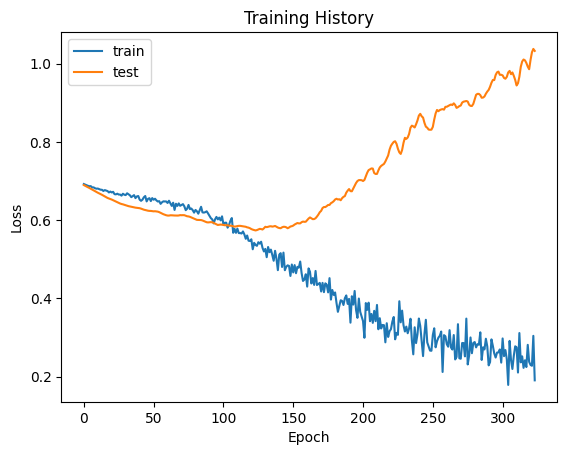

In [69]:
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.title("Training History")
pyplot.legend()
pyplot.show()

In [70]:
def _replaceitem(x):
    if x > 0.1:
        return 1
    else:
        return 0

In [71]:
start_time = time.time()

y_pred = saved_model.predict(X_test)

# print("Train Time: %f seconds" % traintime)
print("Test Time: %s seconds" % (time.time() - start_time))

y_pred = pd.DataFrame({'y_pred': y_pred.round().ravel()})
# y_pred = list(map(_replaceitem, y_pred.ravel()))
results = pd.concat([y_test,y_pred], axis=1)

2/2 [==============================] - 1s 6ms/step
Test Time: 1.374776840209961 seconds


In [72]:
if(len(confusion_matrix(y_test, y_pred).ravel()) > 1):
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  print(tn, fp, fn, tp)
else:
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
ac = accuracy_score(y_test,y_pred)

4 7 2 23


In [73]:
ac

0.75

In [74]:
# from google.colab import drive
# drive.mount('/gdrive')

# model.save('lstmplus.h5')